# 0. 객체탐지(b-box) 모델을 조사
- 조사한 모델이 예상 성능 요구 사항을 충족시킬 수 있는지 확인해주세요. 확인한 내용을 **PPT 1장~3장**으로 정리해서 제출해주세요.
- 모델의 라이센스, 오픈 모델의 성능을 파악해서 왜 해당 모델을 선택했는지 작성이 되어야합니다.
- 업무요청 가이드에서는 yolov5 모델을 baseline모델로 사용하라고 되어있지만, 다른 b-box 모델을 조사했을 때 더 좋은 성능의 모델이 있다면 그 모델로 진행해도 좋습니다.


# 데이터셋 구축
- 아래의 코드 가이드를 참고해서 데이터셋 구축하는 코드를 작성해주세요
- 완료된 데이터셋 구축 코드는 **.ipynb 파일을 다운해서 제출**해주세요.

# 1. Mount google drive
- 코랩을 활용할 경우, 구글 드라이브에 있는 데이터를 사용하기 위해서 마운트 작업이 필요합니다.
- 로컬에서 진행할 경우엔 생략해주세요.
- 로컬에서 진행할 경우엔 conda를 활용하여 가상환경을 세팅해주세요.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Import Library
- 코드에 사용되는 파이썬 라이브러리를 불러옵니다.

In [1]:
import os
import cv2
import glob
import shutil
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm       # 작업 진행 속도를 보는데 유용한 라이브러리입니다.
from sklearn.model_selection import train_test_split

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# warning 무시 코드
warnings.filterwarnings(action='ignore')

In [ ]:
# 현재 실행 파일 경로 확인
os.getcwd()

'/content'

# 3. 데이터셋 준비
- 데이콘의 데이터셋은 차종으로 라벨링 되어 있는데, 우리는 차 종류를 객체탐지하는 것이 아닌 "차"를 객체탐지하는 것이 목표입니다.
- 차 종류로 라벨링 된 text파일 데이터를 수정해야합니다.

In [ ]:
# 기존에 존재하던 데이터셋 폴더 경로 정의
origin_dir = ''  # ex: '/content/drive/MyDrive/comento/1/dataset/data'

# 원본 라벨파일(.txt) 불러오기
origin_label = f'{origin_dir}/*.txt'
label_txts = glob.glob(origin_label)

print('라벨파일(.txt) 개수 : ',len(label_txts))

In [ ]:
# 수정된 라벨을 저장하는 폴더 경로 정의
edit_label_dir = '' # ex: '/content/drive/MyDrive/comento/1/dataset/label_data'

# 수정된 라벨링 데이터 저장 폴더를 생성
if not os.path.exists(edit_label_dir):
    os.mkdir(edit_label_dir)

# 4. Yolo 모델링을 위한 라벨링 데이터 수정
- 모든 데이터의 라벨을 "car"로 변경해야합니다.
- 기존 데이터셋의 Labelme 형태를 yolo format을 따라 라벨링 파일을 변경해야합니다.
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format


### 코드 설계 참고
- 코드를 작성하기 전에 구현하고자하는 로직을 텍스트로 설계해보는 연습도 많이 하면 좋을 것 같습니다.
1. 기존의 모든 라벨 데이터를 읽기모드로 불러와서 반복문으로 데이터 파일을 하나씩 열어줍니다.
2. 1번에서 불러온 라벨데이터(.txt)는 Labelme 형태로 <classId, x1, y1, x2, y2, x3, y3, x4, y4>에 맞게 값을 따로 정의해줍니다.
  - 참고 : strip().split(' ') 라이브러리 활용 가능
3. 모든 데이터의 라벨을 "car" 하나로만 변경해야하므로, classId는 0으로 변경해주세요
4. 2번에서 불러온 좌표값들을 활용하여 yolo 라벨 형태에 맞게 중심좌표와 너비/높이를 계산해줍니다.
5. 수정된 라벨을 새로운 파일로 저장해줍니다. (라벨 파일명은 매칭되는 이미지파일명과 동일해야합니다.)

In [ ]:
# 라벨 데이터 수정 코드 작성


# 5. 라벨이 제대로 수정되었는지 확인하기
- 아래 함수를 통해 라벨이 제대로 수정되었는지 시각화해서 확인해주세요.
- 항상 작업을 완료후에는 결과를 확인하면서 이슈가 없는지 파악해야합니다.

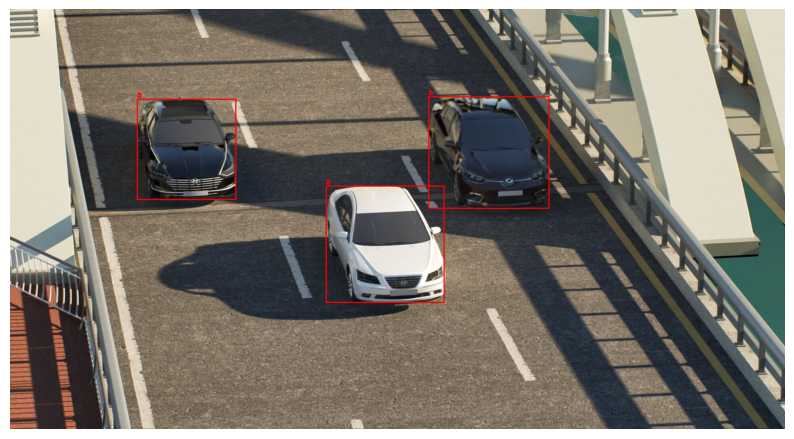

In [ ]:
def draw_boxes_on_image(image_path : str, annotation_path : str,
                        img_width : int, img_height : int):
    ''' 이미지와 바운딩 박스를 그리는 함수
    Args:
        image_path (str): 이미지 파일 경로
        annotation_path (str): 라벨 파일 경로 (.txt)
        img_width (int): 이미지의 너비
        img_height (int): 이미지의 높이
    Returns:
        show image: 이미지와 바운딩 박스가 그려진 이미지
    '''

    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])

        # YOLO 형식의 좌표를 원래 이미지 크기에 맞게 변환
        x_center = values[1] * img_width
        y_center = values[2] * img_height
        box_width = values[3] * img_width
        box_height = values[4] * img_height

        # 좌표 계산
        x_min = int(round(x_center - (box_width / 2)))
        y_min = int(round(y_center - (box_height / 2)))
        x_max = int(round(x_center + (box_width / 2)))
        y_max = int(round(y_center + (box_height / 2)))

        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # 축 숨기기
    plt.show()


#### 검증 함수 실행!!
image_file = os.path.join(origin_dir, 'syn_00068.png')
annotation_file = os.path.join(edit_label_dir, 'syn_00068.txt')
img_width, img_height = Image.open(image_file).size

draw_boxes_on_image(image_file, annotation_file, img_width, img_height)

# 6. train/valid/test set 분리
- 간단한 데이터셋 통계량 확인하고, 데이터셋 비율을 정해줍니다.
  - 차량 데이터 총 개수 확인 (참고 : glob 모듈 사용)
- 학습/검증/테스트셋 분리
  - train_test_split 라이브러리를 활용하여 test_size 인자로 데이터셋 비율을 조절할 수 있습니다. (train_test_split라이브러리는 데이터셋을 분리하는데에 많이 사용되고 있습니다.)
  - trainset : validset : testset  = 6 : 2 : 2

In [ ]:
# 학습/검증/테스트셋 분리


# 7. 학습용 train/valid/test 데이터셋 폴더 생성

- 위에서 분리한 train/valid/testset을 옮겨둘 폴더를 생성하고, 파일을 복사해서 옮겨줍니다.
- 아래의 폴더 구조로 만들어주세요.

```
└── datasets /
    ├── images /
        ├── train /
            ├── 1.png
            ├── 2.png
        ├── val /
            ├── 3.png
            ├── 4.png
        ├── test /
            ├── 5.png
            ├── 6.png
    ├── labels /
        ├── train /
            ├── 1.txt
            ├── 2.txt
        ├── val /
            ├── 3.txt
            ├── 4.txt
        ├── test /
            ├── 5.txt
            ├── 6.txt
```

- 데이터를 저장하고자 하는 곳으로 이동 (참고 : shutil.copy 라이브러리 사용)
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
- 구글드라이브의 용량이 부족하다면 데이터를 조금 더 삭제해서 줄여도 괜찮습니다.

In [ ]:
# 데이터셋 구축 코드 작성



- 학습에 사용되는 .yaml 파일을 아래 형식에 맞춰서 만들어줍니다.

```
names:
- car
nc: 1
path: "dataset_folder_root_path"
test: "test_image_dataset_folder_path"
train: "train_image_dataset_folder_path"
val: "validation_image_dataset_folder_path"
```

In [ ]:
# yaml 파일 생성 코드 작성 후 저장


In [ ]:
# 생성한 YAML 파일 읽기
yaml_path = 'Enter_your_yaml_file_path'

with open(yaml_path, 'r') as f:
    data = yaml.full_load(f)

# 내용 출력
print(data)

{'names': ['car'], 'nc': 1, 'path': '/content/drive/MyDrive/comento/1/datasets_yolo', 'test': '/content/drive/MyDrive/comento/1/datasets_yolo/images/test', 'train': '/content/drive/MyDrive/comento/1/datasets_yolo/images/train', 'val': '/content/drive/MyDrive/comento/1/datasets_yolo/images/val'}
